In [1]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
import os

In [2]:
# Use CPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
print(tensorflow.__version__)

2.8.0


In [4]:
# Dataset
df=pd.read_csv('./../../dataset/raw_jawa_timur.csv', parse_dates=["date"], index_col="date")
#df['daily_case'] = df['daily_case'].str.replace(',','').astype(int)

# Cut dataset to start from 1 April 2022
df = df[14:]
df.head()

,daily_case
date,
2020-04-01,9
2020-04-02,0
2020-04-03,47
2020-04-04,5
2020-04-05,35


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 766 entries, 2020-04-01 to 2022-05-06
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   daily_case  766 non-null    int64
dtypes: int64(1)
memory usage: 12.0 KB


In [6]:
df.shape

(766, 1)

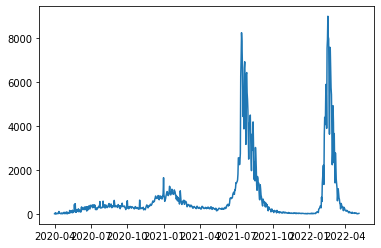

In [7]:
plt.plot(df)

In [8]:
scaler = MinMaxScaler(feature_range=(0,1))

In [9]:
df.shape

(766, 1)

In [10]:
df.head()

,daily_case
date,
2020-04-01,9
2020-04-02,0
2020-04-03,47
2020-04-04,5
2020-04-05,35


In [11]:
# df = scaler.fit_transform(np.array(df).reshape(-1,1))

In [12]:
df.shape

(766, 1)

In [13]:
# Split data to train and test
df = df.values
df = df.astype('float32')
train_size = int(len(df) * 0.75)
test_size=len(df)-train_size

In [14]:
train_data_ns=df[0:train_size,:]
test_data_ns=df[train_size:len(df),:]

In [15]:
# scale data
train_data = scaler.fit_transform(np.array(train_data_ns).reshape(-1,1))
test_data = scaler.fit_transform(np.array(test_data_ns).reshape(-1,1))

In [16]:
train_data.shape

(574, 1)

In [17]:
print(len(train_data)), print(len(test_data))

574
192


(None, None)

In [18]:
# Create dataset matrix based on timestep
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

In [19]:
# Reshape into x=t, t+1, t+2, ... t+n, and Y = t + (n+1)
time_step = 30
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

In [20]:
print(X_train.shape), print(Y_train.shape)

(543, 30)
(543,)


(None, None)

In [21]:
print(X_test.shape), print(Y_test.shape)

(161, 30)
(161,)


(None, None)

In [22]:
len(X_test)

161

In [23]:
# Reshape input data to 3d [sample, time_step, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [24]:
from keras.models import load_model
 
# load model
model = load_model('lstm_jawa_timur.h5')

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [26]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [27]:
Y_train = Y_train.reshape(-1,1)
Y_train = scaler.inverse_transform(Y_train)

X_train = X_train.reshape(-1,1)
X_train = scaler.inverse_transform(X_train)

Y_test = Y_test.reshape(-1,1)
Y_test = scaler.inverse_transform(Y_test)

X_train = Y_train.reshape(-1,1)
X_train = scaler.inverse_transform(X_train)

In [28]:
# Transform back to original value
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

Metric Jawa Timur

In [29]:
# Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
print('RMSE train:', math.sqrt(mean_squared_error(Y_train, train_predict)))

RMSE train: 206.97306021859464


In [30]:
print('RMSE test:', math.sqrt(mean_squared_error(Y_test, test_predict)))

RMSE test: 815.2452851749589


In [31]:
train_data_ns.max(), train_data_ns.min()

(8230.0, 0.0)

In [32]:
# normalized RMSE metrics train
print('NRMSE train:', math.sqrt(mean_squared_error(Y_train, train_predict))/(train_data_ns.max()-train_data_ns.min()))

NRMSE train: 0.025148609990108706


In [33]:
# normalized RMSE metrics test
print('NRMSE test:', math.sqrt(mean_squared_error(Y_test, test_predict))/(test_data_ns.max()-test_data_ns.min()))

NRMSE test: 0.09086550213720006


In [34]:
train_predict

array([[  91.099   ],
       [  95.50914 ],
       [  91.73429 ],
       [  96.677414],
       [  95.62998 ],
       [  97.732704],
       [ 100.01064 ],
       [  99.47587 ],
       [  97.73017 ],
       [ 109.05943 ],
       [ 108.333374],
       [ 106.41934 ],
       [ 114.4656  ],
       [ 126.41323 ],
       [ 130.67232 ],
       [ 132.59909 ],
       [ 147.85416 ],
       [ 146.40143 ],
       [ 151.72824 ],
       [ 151.32227 ],
       [ 154.54187 ],
       [ 196.65527 ],
       [ 192.51337 ],
       [ 236.45511 ],
       [ 230.76826 ],
       [ 254.19768 ],
       [ 266.3081  ],
       [ 282.64697 ],
       [ 286.0512  ],
       [ 271.27402 ],
       [ 255.48291 ],
       [ 243.80869 ],
       [ 215.29346 ],
       [ 205.80057 ],
       [ 203.25697 ],
       [ 195.53497 ],
       [ 195.34865 ],
       [ 187.31143 ],
       [ 201.43768 ],
       [ 215.33379 ],
       [ 207.81305 ],
       [ 219.49048 ],
       [ 234.28485 ],
       [ 252.27907 ],
       [ 268.04584 ],
       [ 2

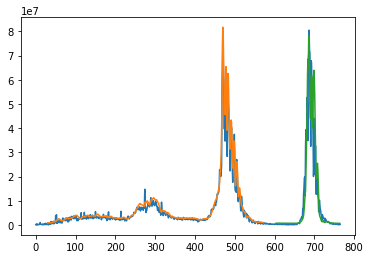

In [35]:
# Plot 
look_back = 30
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

#shift test predict
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict

#plot baseline
plt.plot(scaler.inverse_transform(df))
plt.plot(scaler.inverse_transform(trainPredictPlot))
plt.plot(scaler.inverse_transform(testPredictPlot))
plt.show()

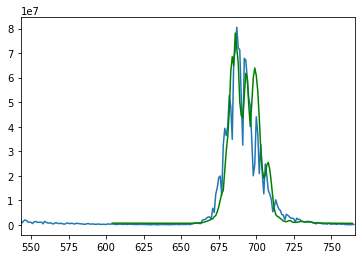

In [36]:
#shift test predict
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict

#plot baseline
plt.plot(scaler.inverse_transform(df))
plt.plot(scaler.inverse_transform(testPredictPlot), 'g')
plt.xlim(X_train.shape[0], df.shape[0])
plt.show()

In [37]:
len(test_data)

192

In [38]:
x_input=test_data[162:].reshape(1,-1) #test data - step(30)
x_input.shape

(1, 30)

In [39]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [40]:
temp_input

[0.01538118626922369,
 0.012929112650454044,
 0.009028087370097637,
 0.008470797911286354,
 0.00479268841445446,
 0.01125724520534277,
 0.00891662947833538,
 0.007133303675800562,
 0.005461435299366713,
 0.004569772630929947,
 0.005572893191128969,
 0.002897904720157385,
 0.00824788212776184,
 0.004012483172118664,
 0.0030093626119196415,
 0.003901025280356407,
 0.003901025280356407,
 0.003120820503681898,
 0.002229157369583845,
 0.005572893191128969,
 0.0030093626119196415,
 0.0024520731531083584,
 0.003901025280356407,
 0.0013374944683164358,
 0.001894783810712397,
 0.00044583145063370466,
 0.00033437361707910895,
 0.001003120793029666,
 0.0014489522436633706,
 0.0021176994778215885]

In [41]:
# prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=30
i=0
while(i<30): #30 hari
    
    if(len(temp_input)>30):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.00724068]
31
1 day input [0.01292911 0.00902809 0.0084708  0.00479269 0.01125725 0.00891663
 0.0071333  0.00546144 0.00456977 0.00557289 0.0028979  0.00824788
 0.00401248 0.00300936 0.00390103 0.00390103 0.00312082 0.00222916
 0.00557289 0.00300936 0.00245207 0.00390103 0.00133749 0.00189478
 0.00044583 0.00033437 0.00100312 0.00144895 0.0021177  0.00724068]
1 day output [[0.0075567]]
2 day input [0.00902809 0.0084708  0.00479269 0.01125725 0.00891663 0.0071333
 0.00546144 0.00456977 0.00557289 0.0028979  0.00824788 0.00401248
 0.00300936 0.00390103 0.00390103 0.00312082 0.00222916 0.00557289
 0.00300936 0.00245207 0.00390103 0.00133749 0.00189478 0.00044583
 0.00033437 0.00100312 0.00144895 0.0021177  0.00724068 0.0075567 ]
2 day output [[0.00784173]]
3 day input [0.0084708  0.00479269 0.01125725 0.00891663 0.0071333  0.00546144
 0.00456977 0.00557289 0.0028979  0.00824788 0.00401248 0.00300936
 0.00390103 0.00390103 0.00312082 0.00222916 0.00557289 0.00300936
 0.00245207 0.0039010

24 day output [[0.02547898]]
25 day input [0.00044583 0.00033437 0.00100312 0.00144895 0.0021177  0.00724068
 0.0075567  0.00784173 0.0081949  0.00873438 0.0094686  0.01035933
 0.01131626 0.01226538 0.01315698 0.01398337 0.01476307 0.0155188
 0.01629552 0.01709804 0.01793136 0.01878934 0.01965686 0.02051872
 0.02136132 0.02219479 0.02301821 0.02383529 0.02465704 0.02547898]
25 day output [[0.02630399]]
26 day input [0.00033437 0.00100312 0.00144895 0.0021177  0.00724068 0.0075567
 0.00784173 0.0081949  0.00873438 0.0094686  0.01035933 0.01131626
 0.01226538 0.01315698 0.01398337 0.01476307 0.0155188  0.01629552
 0.01709804 0.01793136 0.01878934 0.01965686 0.02051872 0.02136132
 0.02219479 0.02301821 0.02383529 0.02465704 0.02547898 0.02630399]
26 day output [[0.02712907]]
27 day input [0.00100312 0.00144895 0.0021177  0.00724068 0.0075567  0.00784173
 0.0081949  0.00873438 0.0094686  0.01035933 0.01131626 0.01226538
 0.01315698 0.01398337 0.01476307 0.0155188  0.01629552 0.01709804
 0.

In [42]:
day_new=np.arange(1,31) # dari data 30 hari terakhir
day_pred=np.arange(31,61) #predict 30 hari kedepan

In [43]:
len(df)

766

In [44]:
len(day_pred)

30

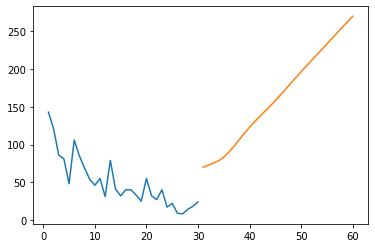

In [45]:
plt.plot(day_new,df[736:]) # [total data - prediction(30)] 
plt.plot(day_pred,scaler.inverse_transform(lst_output))

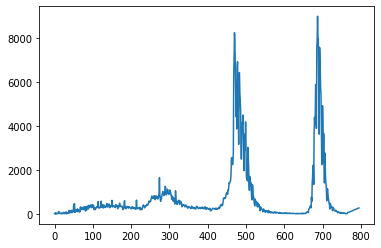

In [46]:
df2=df.tolist()
df2.extend(scaler.inverse_transform(lst_output))
plt.plot(df2)

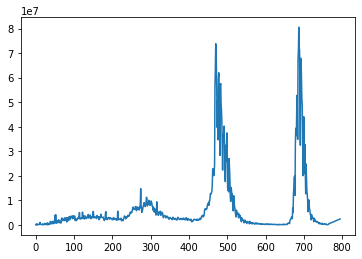

In [47]:
df2=scaler.inverse_transform(df2).tolist()
plt.plot(df2)

In [48]:
scaler.inverse_transform(lst_output)

array([[ 69.96338908],
       [ 72.79868798],
       [ 75.35603868],
       [ 78.52465148],
       [ 83.36483058],
       [ 89.95227975],
       [ 97.94392549],
       [106.52946992],
       [115.04502596],
       [123.04440919],
       [130.45883447],
       [137.45422342],
       [144.23470889],
       [151.20342605],
       [158.40357452],
       [165.88013372],
       [173.57795519],
       [181.3613069 ],
       [189.09392203],
       [196.6537721 ],
       [204.13163481],
       [211.51935487],
       [218.85018846],
       [226.2229683 ],
       [233.59743601],
       [240.99937769],
       [248.40205467],
       [255.75828997],
       [263.04734444],
       [270.19070672]])

In [49]:
# evaluate the model
scores = model.evaluate(X_train, Y_train, verbose=0)
print("%s: %f" % (model.metrics_names[0], scores*100))

loss: 231441550.000000
